This code file is used to firstly identify point of interests in Seattle based on top 55 tourist attractions and popular recreation parks. Then, I will show how I construct a new variable/metric named `"Convenience score"` for each Airbnb property. In other words, I will introduce the contents by two steps below.
- Step 1: How to identify POIs (point of interest) in Seattle?  
    `ToDos` --- geo plot "parks" and "tourist attraction_clean" using maps -!!!
    
- Step 2: Define the Airbnb property's convenience score, and then construct new features for price prediction models.

In [1]:
### Initialize

import pandas as pd 
import numpy as np


### Step 1: How to identify POIs (point of interest) in Seattle?

-	1) Parks and recreation parks.https://www.kaggle.com/city-of-seattle/seattle-parks-and-recreation-data?select=seattle-parks-and-recreation-park-addresses.csv
-	2) Tourist Attractions. 55 Best Things to Do in Seattle (Washington) https://www.thecrazytourist.com/25-best-things-seattle-washington/

Notice that the first "park" data includes completed lat/long information which can be downloaded directly. So I need to collect a list of location names for the "attraction" data and then scrape their latituted and longtitude from https://nominatim.openstreetmap.org/search/ website. Here, I will use `requests` and `urllib.parse` packages to scrape the lat/long information.


1) Parks and recreation parks

In [75]:
park = pd.read_csv("../data/seattle-parks-and-recreation-park-addresses.csv")[['Name', 'Address', 'ZIP Code', 'X Coord', 'Y Coord']]
park = park.rename(columns={'ZIP Code': 'Zipcode', "X Coord": "Long", "Y Coord": "Lat"})
print(park.shape)
park.head(2)

(412, 5)


,Name,Address,Zipcode,Long,Lat
0,12th and Howe Play Park,1200 W Howe St,98119,-122.372985,47.636097
1,12th Ave S Viewpoint,2821 12TH Ave S,98144,-122.317765,47.577953


2) Top 55 Tourist Attractions.
- web scraping
- manually clean

In [14]:
attr = pd.read_csv("../data/seattle_top55 tourist attractions.csv")
attr['Name_city'] = attr['Name'] + ', seattle'
print(attr.shape)
attr.head(2)

(55, 2)


,Name,Name_city
0,Pike Place Market,"Pike Place Market, seattle"
1,Seattle Center,"Seattle Center, seattle"


In [50]:
### web scraping...
import requests
import urllib.parse  
import time         # time.sleep(5) # Delay for 5 seconds.
import random       # random.randrange(1, 4) 

def get_lat_long(address, random_time_delay=4):
    """web scraping, compute the address's geo-info.
    input: 
        - address, string
        - random_time_delay, int
    return: 
        - lat, long, zipcode of this address
    """
    time.sleep( random.randrange(1,random_time_delay) ) # Delay for random_generated seconds. (between 1s and 4s)
    
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    try:
        response = requests.get(url).json()
        return response[0]["lat"], response[0]["lon"], response[0]['display_name'].split(", ")[-2].split('-')[0]
    
    except:
        return 'none', 'none', 'none'


lat_list = []
long_list = []
zipcode_list = []
for address in attr['Name_city']:
    lat, long, zipcode = get_lat_long(address)  ## apply "get_lat_long()" function
    lat_list.append(lat)
    long_list.append(long)
    zipcode_list.append(zipcode)
    
## add three cols to "attr" data
attr['Lat'] = lat_list
attr['Long'] = long_list
attr['Zipcode'] = zipcode_list

In [74]:
### manually clean..
attr.loc[attr['Name'] == 'Pioneer Square', 'Zipcode'] = '98104'

## drop some park tour because it is included in the "park" data
attr = attr[ ~ attr.Name.isin( ["City Highlights Small Group Minivan Tour", \
                                "Mount Rainier Full-Day Walking or Snowshoe Tour", \
                                "Olympic National Park Tour"]) ].reset_index(drop=True)

## for those attractions with "none" in lat/long/zipcode, manually assign the value (from google maps). 
clean_list = [ {'Name': "Bill Speidel's Underground Tour", 'Lat':47.6024, 'Long':-122.3337, 'Zipcode': '98104'}, 
{'Name': "Lake Union Seaplane Flight", 'Lat':47.6286, 'Long':-122.3398, 'Zipcode': '98109'},
{'Name': "Bill & Melinda Gates Foundation Discovery Center", 'Lat':47.6230, 'Long':-122.3473, 'Zipcode': '98109'},
{'Name': "5th Avenue Theatre", 'Lat':47.6094, 'Long':-122.3338, 'Zipcode': '98101'},
{'Name': "The Future of Flight Aviation Center & Boeing Tour", 'Lat':47.921229, 'Long':-122.290160, 'Zipcode': '98275'},
{'Name': "Bruce Lee Grave Site", 'Lat':47.6338, 'Long':-122.3159, 'Zipcode': '98112'},
{'Name': "Woodinville Wine Country", 'Lat':47.7521, 'Long':-122.1584, 'Zipcode': '98072'} ]

for x in clean_list:
    idx = attr.Name == x['Name'] 
    attr.loc[idx, 'Lat'] = x['Lat']
    attr.loc[idx, 'Long'] = x['Long']
    attr.loc[idx, 'Zipcode'] = x['Zipcode']
    
attr

,Name,Name_city,Lat,Long,Zipcode
0,Pike Place Market,"Pike Place Market, seattle",47.60939675,-122.34141017673986,98101
1,Seattle Center,"Seattle Center, seattle",47.62173695,-122.35153998174371,98109
2,Space Needle,"Space Needle, seattle",47.6205131,-122.34930359883187,98109
3,Chihuly Garden and Glass,"Chihuly Garden and Glass, seattle",47.6205296,-122.35020712496446,98109
4,Museum of Pop Culture,"Museum of Pop Culture, seattle",47.621436849999995,-122.34822375173397,98109
5,Seattle Art Museum (SAM),"Seattle Art Museum (SAM), seattle",47.616355,-122.3539764,98121
6,Olympic Sculpture Park,"Olympic Sculpture Park, seattle",47.6162378,-122.35431328817567,98121
7,Pacific Science Center,"Pacific Science Center, seattle",47.61934015,-122.35077847477159,98109
8,Seattle Great Wheel,"Seattle Great Wheel, seattle",47.6061778,-122.342564,98101
9,Ballard Locks,"Ballard Locks, seattle",47.665981200000004,-122.39758960282228,98107


In [76]:
## save as "tourist attractions_clean.csv"
attr.to_csv("../data/tourist attractions_clean.csv", header=True, index=False)


##### -------------------------------------------

### ToDos --- geo plot "parks" and "tourist attraction_clean" using maps -!!!

##### -------------------------------------------

### Step 2: Define the Airbnb property's convenience score:
- Given a circle threshold such as c = 2km, for each Airbnb property, create two convenience score-related variables: 
    - 1) "cs_2_counts": count the number of parks (or attractions) within the c=2km circle, which set the property as the center point. 
    - 2) "cs_2_avgdist": average distance of those chosen parks (or attractions) within the c=2km circle.

- Then, replicate the above process with various values of circle threshold. Here, I will use c=1,2,..10.

In [2]:
listings = pd.read_csv("../data/listings.csv")[["id", "latitude","longitude","is_location_exact",\
                                               "neighbourhood_group_cleansed", "neighbourhood_cleansed", "neighbourhood"]]
print(listings.shape)
listings.head(2)

(3818, 7)


,id,latitude,longitude,is_location_exact,neighbourhood_group_cleansed,neighbourhood_cleansed,neighbourhood
0,241032,47.636289,-122.371025,t,Queen Anne,West Queen Anne,Queen Anne
1,953595,47.639123,-122.365666,t,Queen Anne,West Queen Anne,Queen Anne


In [3]:
print("the number of unique listing_id: ", listings.id.nunique())
print("\nthe distribution of is_location_exact: \n\t", listings.is_location_exact.value_counts())
print("\nthe number of unique neighbourhood: ", listings.neighbourhood.nunique())
print("the number of unique neighbourhood_cleansed: ", listings.neighbourhood_cleansed.nunique())
print("the number of unique neighbourhood_group_cleansed: ", listings.neighbourhood_group_cleansed.nunique(),\
     ', which is the one that Airbnb uses as location feature.')

the number of unique listing_id:  3818

the distribution of is_location_exact: 
	 t    3412
f     406
Name: is_location_exact, dtype: int64

the number of unique neighbourhood:  81
the number of unique neighbourhood_cleansed:  87
the number of unique neighbourhood_group_cleansed:  17 , which is the one that Airbnb uses as location feature.


Given above information, we found that:
- most of properties have exact location info (lat/long), 3412 out of 3818. Only 406 properties do not provide exact lat and long. But in general, the hosts would provide a location that is close to the property. So we can assume that the lat/long provided by the hosts are roughly exact locations to compute the convenience score, no matter they are exact or not. 
- another intesterting finding is that, Airbnb uses "neighbourhood_group_cleansed" as location feature to predict the price, which only has 17 unique indicators. It indicates that two other location features "neighbourhood" with 81 unique values and "neighbourhood_cleansed" with 87 unique values might lead to worse prediction performance compared to that with "neighbourhood_group_cleansed" feature. That is, it is possible that a cluster of neighourhoods share similar unobserved effects on properties' prices. 

Notice that, in this project, I will create a new type of feature `"convenience score"` as location feature, and see if this helps to predict the property's price.

Euclidean Distance works for the flat surface like a Cartesian plain however, Earth is not flat. So we have to use a special type of formula known as `Haversine Distance`. Haversine Distance can be defined as the angular distance between two locations on the Earth’s surface.

In [9]:
# !pip install haversine
import haversine as hs

def get_haversine_distance(coor_prop, coor_attr):
    """compute the distance between two locations based on the lat/long info.
    input:
        - coor_prop: the property's (lat, long)
        - coor_attr: the attraction's (lat, long)
    return:
        - haversine distance
    """
    return round( hs.haversine(coor_prop, coor_attr), 3)  ## unit in km.


In [10]:
# concatenating lat and long to create a consolidated location as accepted by havesine function
listings['coor'] = list(zip(listings.latitude, listings.longitude))
print(listings.shape)
print( listings.head(2) )

park = pd.read_csv("../data/seattle-parks-and-recreation-park-addresses.csv")[['Name', 'X Coord', 'Y Coord']]
park = park.rename(columns={"X Coord": "Long", "Y Coord": "Lat"})
park['Name'] = 'park_' + park['Name'] 
park['coor'] = list(zip(park.Lat, park.Long))


attr = pd.read_csv("../data/tourist attractions_clean.csv")[['Name', 'Lat', 'Long']]
attr['Name'] = 'attr_' + attr['Name'] 
attr['coor'] = list(zip(attr.Lat, attr.Long))

## stack park and attr 
park_attr = pd.concat([park, attr]).reset_index(drop = True)
print('\n', park_attr.shape)
park_attr.head(2)


(3818, 471)
       id   latitude   longitude is_location_exact  \
0  241032  47.636289 -122.371025                 t   
1  953595  47.639123 -122.365666                 t   

  neighbourhood_group_cleansed neighbourhood_cleansed neighbourhood  \
0                   Queen Anne        West Queen Anne    Queen Anne   
1                   Queen Anne        West Queen Anne    Queen Anne   

                                        coor  park_12th and Howe Play Park  \
0  (47.636289038357184, -122.37102519997765)                         0.148   
1   (47.63912312136253, -122.36566646439582)                         0.643   

   park_12th Ave S Viewpoint  ...  attr_Dick's Drive-In  \
0                      7.617  ...                 6.688   
1                      7.692  ...                 6.389   

   attr_Wing Luke Museum  attr_Center for Wooden Boats  attr_Add-a-Ball  \
0                  5.561                         2.820            2.124   
1                  5.563                        

,Name,Long,Lat,coor
0,park_12th and Howe Play Park,-122.372985,47.636097,"(47.636097, -122.37298500000001)"
1,park_12th Ave S Viewpoint,-122.317765,47.577953,"(47.577953, -122.317765)"


In [11]:
# running a loop which will parse listings location one by one to distance from function 
for _,row in park_attr.iterrows():
    listings[row.Name] = listings['coor'].apply(lambda x: get_haversine_distance(row.coor, x))

In [12]:
print(listings.shape)
listings.head()

(3818, 471)


,id,latitude,longitude,is_location_exact,neighbourhood_group_cleansed,neighbourhood_cleansed,neighbourhood,coor,park_12th and Howe Play Park,park_12th Ave S Viewpoint,...,attr_Dick's Drive-In,attr_Wing Luke Museum,attr_Center for Wooden Boats,attr_Add-a-Ball,attr_Amazon Spheres,attr_5th Avenue Theatre,attr_Waterfront Park,attr_The Future of Flight Aviation Center & Boeing Tour,attr_Bruce Lee Grave Site,attr_Woodinville Wine Country
0,241032,47.636289,-122.371025,t,Queen Anne,West Queen Anne,Queen Anne,"(47.636289038357184, -122.37102519997765)",0.148,7.617,...,6.688,5.561,2.820,2.124,3.294,4.089,3.946,32.255,4.140,20.471
1,953595,47.639123,-122.365666,t,Queen Anne,West Queen Anne,Queen Anne,"(47.63912312136253, -122.36566646439582)",0.643,7.692,...,6.389,5.563,2.595,1.644,3.265,4.078,4.015,31.872,3.776,19.961
2,3308979,47.629724,-122.369483,t,Queen Anne,West Queen Anne,Queen Anne,"(47.629724131577355, -122.3694831756176)",0.756,6.941,...,7.420,4.946,2.532,2.707,2.739,3.501,3.290,32.951,4.041,20.851
3,7421966,47.638473,-122.369279,t,Queen Anne,West Queen Anne,Queen Anne,"(47.63847320176642, -122.36927912263019)",0.383,7.759,...,6.448,5.666,2.798,1.850,3.380,4.186,4.081,31.992,4.033,20.217
4,278830,47.632918,-122.372471,t,Queen Anne,West Queen Anne,Queen Anne,"(47.63291840276724, -122.37247063402224)",0.356,7.360,...,7.063,5.356,2.813,2.497,3.130,3.904,3.707,32.643,4.240,20.793


Given a circle threshold such as c = 2km, for each Airbnb property, create two convenience score-related variables:

1) "cs_2_counts": count the number of parks (or attractions) within the c=2km circle, which set the property as the center point. 

2) "cs_2_avgdist": average distance of those chosen parks (or attractions) within the c=2km circle.
Then, replicate the above process with various values of circle threshold. Here, I will use c=1,2,3...10.


In [15]:
def get_convenience_score( listings_row, park_names, circle_thre = 2.0):
    """ compute two convenience-score-related features, cs_counts and cs_avgdist.
    input: 
        - listings_row: this one-row dataframe represents a property, \
                multiple cols that include the Haversine distance to various parks/attractions.
        - park_names: colnames with either "park_" // or "attr_"
        - circle_thre: a numeric value for the maximum of Haversine distance from the property to the park/attraction.
    
    return: 
        - cs_counts: the number of parks and attractions within the circle_thre circle, 
        - cs_avgdist: average distance of those chosen parks and attractions within the circle_thre circle.
    """
    select_cols = park_names[ listings_row[park_names] < circle_thre ]
    cs_counts = len(select_cols)
    cs_avgdist = round( listings_row[select_cols].mean(), 3)
    return cs_counts, cs_avgdist


In [16]:
### compute the convenience score features for Parks ...
park_names = listings.columns[ listings.columns.str.contains('park_') ]
# running a loop which will insert the circle_thre one by one (from 1 to 10) 
for circle_thre in range(1,11):
    cs_counts_name = 'cs_park_{}_counts'.format(circle_thre)
    cs_avgdist_name = 'cs_park_{}_avgdist'.format(circle_thre)
    
    out_ = listings.apply(lambda x: get_convenience_score(x, park_names, circle_thre), axis=1)
    listings[cs_counts_name] = [x[0] for x in out_]
    listings[cs_avgdist_name] = [x[1] for x in out_]

    
### compute the convenience score features for Attractions...
attr_names = listings.columns[ listings.columns.str.contains('attr_') ]
# running a loop which will insert the circle_thre one by one (from 1 to 10) 
for circle_thre in range(1,11):
    cs_counts_name = 'cs_attr_{}_counts'.format(circle_thre)
    cs_avgdist_name = 'cs_attr_{}_avgdist'.format(circle_thre)
    
    out_ = listings.apply(lambda x: get_convenience_score(x, attr_names, circle_thre), axis=1)
    listings[cs_counts_name] = [x[0] for x in out_]
    listings[cs_avgdist_name] = [x[1] for x in out_]
    
listings[ listings.columns[ listings.columns.str.contains('cs_') ] ].head()

,cs_park_1_counts,cs_park_1_avgdist,cs_park_2_counts,cs_park_2_avgdist,cs_park_3_counts,cs_park_3_avgdist,cs_park_4_counts,cs_park_4_avgdist,cs_park_5_counts,cs_park_5_avgdist,...,cs_attr_6_counts,cs_attr_6_avgdist,cs_attr_7_counts,cs_attr_7_avgdist,cs_attr_8_counts,cs_attr_8_avgdist,cs_attr_9_counts,cs_attr_9_avgdist,cs_attr_10_counts,cs_attr_10_avgdist
0,8,0.636,37,1.313,60,1.788,106,2.559,145,3.089,...,44,3.596,48,3.839,48,3.839,48,3.839,48,3.839
1,8,0.652,38,1.300,63,1.796,116,2.558,150,3.003,...,44,3.506,47,3.686,48,3.756,48,3.756,48,3.756
2,9,0.546,34,1.277,57,1.769,93,2.392,151,3.186,...,45,3.280,46,3.339,48,3.509,48,3.509,48,3.509
3,8,0.663,39,1.353,60,1.775,111,2.578,143,3.002,...,44,3.628,48,3.867,48,3.867,48,3.867,48,3.867
4,9,0.674,36,1.310,56,1.744,98,2.517,144,3.153,...,45,3.570,47,3.698,48,3.768,48,3.768,48,3.768


In [17]:
listings[ listings.columns[ listings.columns.str.contains('cs_') ] ].describe()

,cs_park_1_counts,cs_park_1_avgdist,cs_park_2_counts,cs_park_2_avgdist,cs_park_3_counts,cs_park_3_avgdist,cs_park_4_counts,cs_park_4_avgdist,cs_park_5_counts,cs_park_5_avgdist,...,cs_attr_6_counts,cs_attr_6_avgdist,cs_attr_7_counts,cs_attr_7_avgdist,cs_attr_8_counts,cs_attr_8_avgdist,cs_attr_9_counts,cs_attr_9_avgdist,cs_attr_10_counts,cs_attr_10_avgdist
count,3818.000000,3812.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.00000,3793.000000,3818.000000,3815.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,8.745940,0.655679,31.348350,1.290298,63.526192,1.907907,99.326873,2.489963,134.952593,3.034790,...,29.58198,3.466863,34.179675,3.933217,38.215034,4.300410,41.290204,4.585539,43.775799,4.836950
std,4.412499,0.097935,14.280552,0.107928,28.139822,0.131405,39.353220,0.173992,47.063891,0.240508,...,15.87765,1.093892,14.342463,1.358219,12.522555,1.578722,10.410622,1.787789,8.323592,1.936563
min,0.000000,0.118000,4.000000,0.787000,7.000000,1.117000,13.000000,1.578000,17.000000,2.053000,...,0.00000,0.640000,0.000000,1.305000,1.000000,1.305000,2.000000,1.305000,2.000000,1.668000
25%,5.000000,0.596000,19.000000,1.231000,38.000000,1.844000,61.000000,2.401000,93.000000,2.829000,...,12.00000,2.459000,25.000000,2.576000,36.000000,2.743250,42.000000,2.880250,45.000000,3.006500
50%,8.000000,0.660000,33.000000,1.298000,66.000000,1.910000,111.000000,2.487000,151.000000,3.067000,...,39.00000,3.611000,42.000000,4.058000,44.000000,4.253000,46.000000,4.340000,47.000000,4.495000
75%,13.000000,0.719000,44.000000,1.360000,86.000000,1.985000,132.000000,2.597000,177.000000,3.213000,...,43.00000,4.337000,44.000000,5.152000,46.000000,5.801500,47.000000,6.370750,48.000000,6.642750
max,21.000000,0.989000,60.000000,1.619000,117.000000,2.297000,157.000000,3.007000,196.000000,3.749000,...,45.00000,5.966000,48.000000,6.937000,48.000000,7.462000,48.000000,8.295000,48.000000,9.248000


In [18]:
## save as "listing_cs.csv"

listings_orig = pd.read_csv("../data/listings.csv")
print(listings_orig.shape)

listings_cs = pd.concat([ listings_orig, listings[ listings.columns[ listings.columns.str.contains('cs_|park_|attr_') ] ] ], axis=1 )
listings_cs.to_csv("../data/listings_cs.csv", header=True, index=False)

print(listings_cs.shape)

(3818, 92)
(3818, 595)


The correlation between various types of property's convenience scores and property's price. Notice that the price here means the Base Price (Set before scaped date).

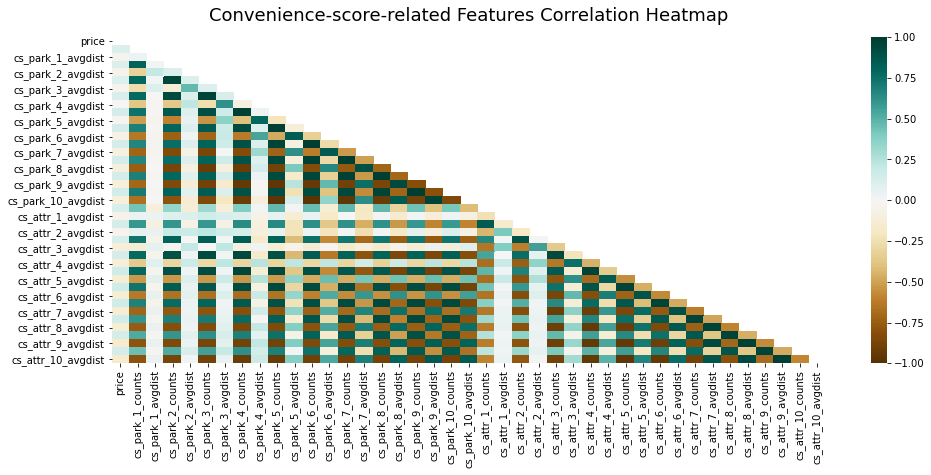

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

### read 
listings_cs = pd.read_csv("../data/listings_cs.csv")

listings_cs['price'] = listings_cs.price.str.replace('$', '').str.replace(',', '').astype(float)
# listings_cs['weekly_price'] = listings_cs.weekly_price.str.replace('$', '').str.replace(',', '').astype(float)
# listings_cs['monthly_price'] = listings_cs.monthly_price.str.replace('$', '').str.replace(',', '').astype(float)

heatmap_dta = listings_cs[ listings_cs.columns[ listings_cs.columns.str.contains('cs_|price') ] ]
mask = np.triu(np.ones_like(heatmap_dta.corr(), dtype=np.bool))

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(heatmap_dta.corr(), vmin=-1, vmax=1,  mask=mask, annot=False,  cmap='BrBG')
heatmap.set_title('Convenience-score-related Features Correlation Heatmap', fontdict={'fontsize':18}, pad=16);


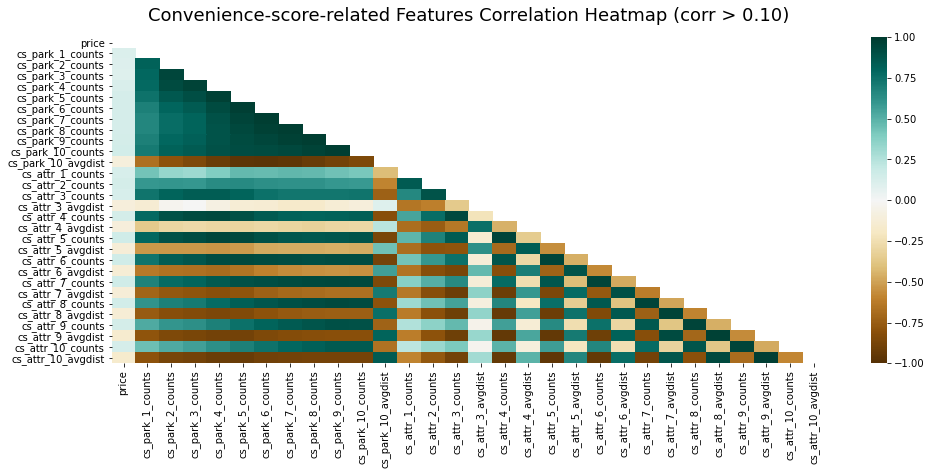

In [24]:
def clean_corr(df, target, threshold):
    """Return df.corr() that greater or equal than threshold.
    
    Args:
        df (dataframe): dataframe
        target (str): col name of target
        threshold (float): The miniumu required correlation coefficient.
        
    Returns:
        df.corr()
    """
    df = df.corr().copy()
    
    for col in df.columns:
        if abs(df.loc[col, target]) < threshold:
            df.drop(col, axis=0, inplace=True)
            df.drop(col, axis=1, inplace=True)
    return df

X_corr = clean_corr(heatmap_dta, 'price', 0.1)
mask = np.triu(np.ones_like(X_corr, dtype=np.bool))

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_corr, vmin=-1, vmax=1,  mask=mask, annot=False,  cmap='BrBG') 
heatmap.set_title('Convenience-score-related Features Correlation Heatmap (corr > 0.10)', fontdict={'fontsize':18}, pad=16);

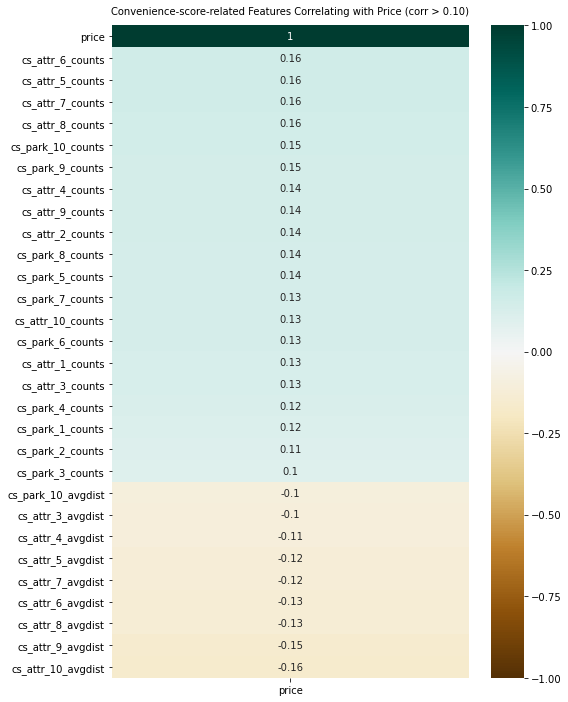

In [23]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(X_corr[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Convenience-score-related Features Correlating with Price (corr > 0.10)', fontdict={'fontsize':10}, pad=11);

The above heatmaps show that, 
- 1) `the attraction-related convenience scores have the highest absolute correlation values with the property's price.` For example, "cs_attr_6_counts" with 0.16 positive correlation value and "cs_attr_10_avgdist" with -0.16 negative correlation value. It indicates that if we assume the property as a center of the circle, the number of attractions within the radius of 6 kilometers are positively associated with the property's price. Similarly, the average distance to attractions within the radisu of 10 kilometers are negatively associated with the property's price. In sum, the property's price is higher when it is close to more attractions.  

- 2) `compared to park-related convenience score (cs_park_...), the attraction-related convenience scores (cs_attr_...) have larger correlations with the property's price.`

- 3) `those convenience score with "cs_counts"` are highly correlated with each other which is reasonable. Because "cs_park_3_counts" is obtained by adding additional number of parks within 2-3 radius on the value of "cs_park_2_counts". It indicates that those highly correlated features might not be included into the prediction model simultanously, which lead to collinearly issues. Therefore, I will only use `"cs_attr_5_counts"` and `"cs_park_5_counts"` as new features for modeling.

- 4) Similarly, `those convenience score with "cs_avgdist"` are highly correlated with each other. I will use `"cs_attr_10_avgdist"` and `"cs_park_10_avgdist"` as new features for modeling.

### Summary
I will use the following four convenience-score-related features for modeling:
- `"cs_attr_5_counts"`
- `"cs_park_5_counts"` 
- `"cs_attr_10_avgdist"`
- `"cs_park_10_avgdist"`

Note: all features are stored in "`../data/listing_cs.csv`" 

Note: try other features if needed.